I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [1]:
"""!pip install /kaggle/input/polars-for-student/polars-0.16.9-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install /kaggle/input/polars-for-student/typing_extensions-4.5.0-py3-none-any.whl"""

'!pip install /kaggle/input/polars-for-student/polars-0.16.9-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl\n!pip install /kaggle/input/polars-for-student/typing_extensions-4.5.0-py3-none-any.whl'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [3]:
targets = pd.read_csv('./train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/predict-student-performance-from-game-play/train_labels.csv'

In [ ]:
gc.collect()

21

In [ ]:
train_dtypes = {"session_id": pl.Int64,"elapsed_time": pl.Int64,"event_name": pl.Categorical,
                "name": pl.Categorical,"level": pl.Int8,"page": pl.Float32,
                "room_coor_x": pl.Float32,"room_coor_y": pl.Float32,"screen_coor_x": pl.Float32,
                "screen_coor_y": pl.Float32,"hover_duration": pl.Float32,"text": pl.Utf8,
                "fqid": pl.Utf8,"room_fqid": pl.Categorical,"text_fqid": pl.Utf8,
                "fullscreen": pl.Int8,"hq": pl.Int8,"music": pl.Int8,"level_group": pl.Categorical
               }

In [ ]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

In [ ]:
%%time

# we prepare the dataset for the training by level :
df = (pl.read_csv("./train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))
#df = reduce_mem_usage_pl(df)

print(f'df loaded with shape: {df.shape}')

df loaded with shape: (26296946, 18)
CPU times: user 40.9 s, sys: 15.1 s, total: 56 s
Wall time: 53.4 s


In [ ]:
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

print(f'df1 loaded with shape: {df1.shape}')
print(f'df2 loaded with shape: {df2.shape}')
print(f'df3 loaded with shape: {df3.shape}')

del df
gc.collect()

df1 loaded with shape: (3981005, 18)
df2 loaded with shape: (8844238, 18)
df3 loaded with shape: (13471703, 18)


51

In [ ]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

NUMS = [ 
    'page', 
    'room_coor_x', 
    'room_coor_y', 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]


# ----------------From another Notebook https://www.kaggle.com/code/xiaosufrankhu/lgbm-train-infer-with-cpu
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']
# DIALOGS = ['Gramps','myself', 'national movement', 'Wisconsin Wonders','Earth Day', '1916', 'cleaning', 'cleaner', 'slip', 'jersey', 'Theodora Youmans', 'suffragist', 'that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']
LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [ ]:
def feature_engineer(x, grp, use_extra, feature_suffix):
        
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.25).alias(f"{c}_q25_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.75).alias(f"{c}_q75_{feature_suffix}") for c in NUMS],

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.25).alias(f'word_q25_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.75).alias(f'word_q75_{c}') for c in DIALOGS],

        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in event_name_feature],

        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in name_feature],
        
        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in LEVELS],
        
        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in text_lists],
        
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in room_lists],
        
        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in fqid_lists],
    ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [ ]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print(f'df1 done with shape: {df1.shape}')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print(f'df2 done with shape: {df2.shape}')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print(f'df3 done with shape: {df3.shape}')

df1 done with shape: (23562, 2349)
df2 done with shape: (23562, 2355)
df3 done with shape: (23562, 2353)
CPU times: user 6min 59s, sys: 7.83 s, total: 7min 7s
Wall time: 3min 52s


Remove some redundant features

In [ ]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

1428 1098 948


  0%|          | 0/2349 [00:00<?, ?it/s]

word_found
word_wells
word_Oh
word_flag
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
tunic.historicalsociety.cage.confrontation_text_fqid_counts
tunic.wildlife.center.crane_ranger.crane_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.wildlife.center.wells.nodeer_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.have_glass_text_fqid_counts
tunic.drycleaner.frontdesk.worker.hub_text_fqid_counts
tunic.historicalsociety.closet_dirty.gramps.news_text_fqid_counts
tunic.humanecology.frontdesk.worker.intro_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_text_fqid_counts
tunic.historicalsociety.basement.seescratches_text_fqid_counts
tunic.flaghouse.entry.flag_girl.hello_text_fqid_counts
t

  0%|          | 0/2355 [00:00<?, ?it/s]

word_Found
word_notebook
word_wells
word_flag
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
tunic.historicalsociety.cage.confrontation_text_fqid_counts
tunic.wildlife.center.crane_ranger.crane_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_text_fqid_counts
tunic.wildlife.center.wells.nodeer_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_text_fqid_counts
tunic.historicalsociety.basement.seescratches_text_fqid_counts
tunic.historicalsociety.collection.cs_text_fqid_counts
tunic.flaghouse.entry.flag_girl.hello_text_fqid_counts
tunic.historicalsociety.collection.gramps.found_text_fqid_counts
tunic.historicalsociety.basement.ch3start_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_flag_text_fqid_counts
tunic.historicalsociety.collection_flag.gramps.flag_text_fqid_counts
tunic.hi

  0%|          | 0/2353 [00:00<?, ?it/s]

word_Found
word_notebook
word_wells
1_LEVEL_count
2_LEVEL_count
3_LEVEL_count
4_LEVEL_count
5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.historicalsociety.entry.groupconvo_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.have_glass_text_fqid_counts
tunic.drycleaner.frontdesk.worker.hub_text_fqid_counts
tunic.historicalsociety.closet_dirty.gramps.news_text_fqid_counts
tunic.humanecology.frontdesk.worker.intro_text_fqid_counts
tunic.historicalsociety.collection.cs_text_fqid_counts
tunic.historicalsociety.collection.gramps.found_text_fqid_counts
tunic.library.frontdesk.worker.hello_text_fqid_counts
tunic.library.frontdesk.worker.wells_text_fqid_counts
tunic.historicalsociety.frontdesk.archivist.hello_text_fqid_counts
tunic.historicalsociety.closet.gramps.intro_0_cs_0_text_fqid_counts
tunic.historicalsociety.closet_dirty.trigger_scar

In [ ]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [ ]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 695 1091 1283 features
We will train with 23562 users info


In [ ]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL, PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

#########################
### question 1 with features 695
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
plaque_fqid_counts,0.016067
cutscene_click_ET_median_,0.014492
tunic.historicalsociety.collection.cs_ET_median_,0.013727
chap1_finale_c_ET_sum_,0.010843
tunic.historicalsociety.collection.cs_ET_q25_,0.009333
tunic.historicalsociety.collection_room_fqid_counts,0.009046
word_q25_the,0.008320
checkpoint_ET_sum_,0.008307
cs_ET_median_,0.007849


#########################
### question 2 with features 695
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_ET_q25_,0.006313
basic_ET_median_,0.006229
tunic.historicalsociety.collection.gramps.found_ET_q25_,0.005456
3_LEVEL_count,0.005229
checkpoint_ET_sum_,0.004888
word_median_help,0.004813
word_q25_it,0.004684
4_ET_sum_,0.004476
chap1_finale_c_ET_sum_,0.004440


#########################
### question 3 with features 695
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
plaque_fqid_counts,0.005565
tunic.historicalsociety.collection_room_fqid_counts,0.005044
checkpoint_ET_sum_,0.004926
session_number_,0.004411
tunic.capitol_0.hall_ET_sum_,0.004278
word_q75_you,0.004094
chap1_finale_c_ET_sum_,0.003811
word_mean_you,0.003649
3_LEVEL_count,0.003512


#########################
### question 4 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
person_click_ET_q25_,0.032749
worker_ET_q25_,0.020691
tunic.drycleaner.frontdesk.worker.hub_ET_q25_,0.018263
basic_ET_q25_,0.016476
tunic.library.frontdesk.worker.wells_ET_median_,0.012409
word_q25_the,0.011124
tunic.library.frontdesk.worker.wells_ET_q25_,0.010402
word_q25_is,0.009854
word_q25_to,0.008580


#########################
### question 5 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.015639
11_LEVEL_count,0.011081
tunic.historicalsociety.stacks_room_fqid_counts,0.008482
worker_ET_q25_,0.008230
tunic.humanecology.frontdesk.worker.intro_ET_q25_,0.005945
toentry_fqid_counts,0.005469
word_the,0.005441
tunic.drycleaner.frontdesk.worker.hub_ET_q25_,0.004809
person_click_ET_q25_,0.004305


#########################
### question 6 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.015854
11_LEVEL_count,0.011048
text_fqid_unique_,0.009486
tunic.historicalsociety.stacks_room_fqid_counts,0.006617
word_to,0.004331
journals.pic_1.next_fqid_counts,0.004158
reader_bingo_indexCount,0.003895
word_the,0.003602
toentry_fqid_counts,0.003483


#########################
### question 7 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.013262
toentry_fqid_counts,0.010593
11_LEVEL_count,0.008893
worker_ET_q25_,0.005384
person_click_ET_q25_,0.005209
tunic.historicalsociety.frontdesk_room_fqid_counts,0.005062
basic_ET_q25_,0.004095
tunic.historicalsociety.stacks_room_fqid_counts,0.003855
word_q25_to,0.003546


#########################
### question 8 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.007426
11_LEVEL_count,0.006707
word_the,0.003709
person_click_ET_q25_,0.003636
tunic.drycleaner.frontdesk.worker.hub_ET_median_,0.003541
word_to,0.003311
word_q25_the,0.003201
word_q25_is,0.002916
object_click_ET_sum_,0.002676


#########################
### question 9 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.018315
11_LEVEL_count,0.011394
text_fqid_unique_,0.008710
word_to,0.006957
word_the,0.005227
reader_bingo_indexCount,0.003792
tunic.historicalsociety.stacks_room_fqid_counts,0.003398
9_LEVEL_count,0.003303
worker_ET_q25_,0.003194


#########################
### question 10 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
11_LEVEL_count,0.018112
session_number_,0.013740
tunic.historicalsociety.stacks_room_fqid_counts,0.007445
person_click_ET_q25_,0.004437
journals_bingo_indexCount,0.003636
tunic.historicalsociety.frontdesk_room_fqid_counts,0.003563
worker_ET_q25_,0.003328
reader_fqid_counts,0.003173
tunic.historicalsociety.closet_dirty.gramps.news_ET_q25_,0.002922


#########################
### question 11 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
11_LEVEL_count,0.012992
session_number_,0.010526
tunic.historicalsociety.stacks_room_fqid_counts,0.004735
object_click_ET_sum_,0.004533
tunic.historicalsociety.frontdesk_room_fqid_counts,0.002928
reader_fqid_counts,0.002863
word_std_this,0.002850
map_click_ET_sum_,0.002836
undefined_ET_sum_,0.002523


#########################
### question 12 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.006547
9_LEVEL_count,0.004767
toentry_fqid_counts,0.004403
tunic.historicalsociety.frontdesk_room_fqid_counts,0.003851
basic_ET_q25_,0.003788
11_LEVEL_count,0.003452
word_the,0.002997
tostacks_fqid_counts,0.002614
tunic.historicalsociety.stacks_room_fqid_counts,0.002349


#########################
### question 13 with features 1091
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
object_click_ET_sum_,0.018957
journals_bingo_indexCount,0.008481
room_fqid_unique_,0.006170
journals.pic_2.next_ET_sum_,0.006035
11_LEVEL_count,0.005869
tunic.historicalsociety.stacks_room_fqid_counts,0.004600
businesscards_fqid_counts,0.004277
reader.paper1.next_ET_sum_,0.003588
object_hover_ET_sum_,0.003444


#########################
### question 14 with features 1283
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.017644
word_to,0.015811
word_the,0.008520
tocloset_dirty_fqid_counts,0.005782
flag_girl_fqid_counts,0.005475
tocloset_dirty_ET_std_,0.004657
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,0.004585
20_LEVEL_count,0.004568
tunic.flaghouse.entry.flag_girl.symbol_recap_text_fqid_counts,0.004405


#########################
### question 15 with features 1283
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
word_to,0.015714
tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.010172
session_number_,0.009546
flag_girl_fqid_counts,0.009290
directory_fqid_counts,0.008193
tunic.historicalsociety.entry.groupconvo_flag_ET_median_,0.007265
worker_fqid_counts,0.005502
word_sum_Jo,0.005466
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,0.005136


#########################
### question 16 with features 1283
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
word_q75_the,0.003246
word_q75_to,0.003104
map_hover_ET_sum_,0.002609
session_number_,0.002288
tunic.wildlife.center.wells.nodeer_ET_q75_,0.002059
screen_coor_x_q25_,0.002050
tunic.library.frontdesk.worker.nelson_ET_sum_,0.001995
tunic.wildlife.center_room_fqid_counts,0.001932
notification_click_ET_median_,0.001913


#########################
### question 17 with features 1283
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_ET_sum_,0.006488
tunic.wildlife.center_ET_sum_,0.006265
word_sum_flag,0.005273
19_ET_sum_,0.004814
tunic.library.frontdesk_ET_sum_,0.003377
tunic.flaghouse.entry_ET_sum_,0.003350
word_mean_flag,0.002895
21_ET_sum_,0.002676
20_ET_sum_,0.002607


#########################
### question 18 with features 1283
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.004014
close_ET_sum_,0.003799
map_hover_ET_sum_,0.003586
flag_girl_fqid_counts,0.003059
tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.003035
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.002818
word_to,0.002517
tunic.flaghouse.entry.flag_girl.symbol_recap_text_fqid_counts,0.002491
20_LEVEL_count,0.002472


CPU times: user 16min 34s, sys: 25.1 s, total: 16min 59s
Wall time: 15min 59s


0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

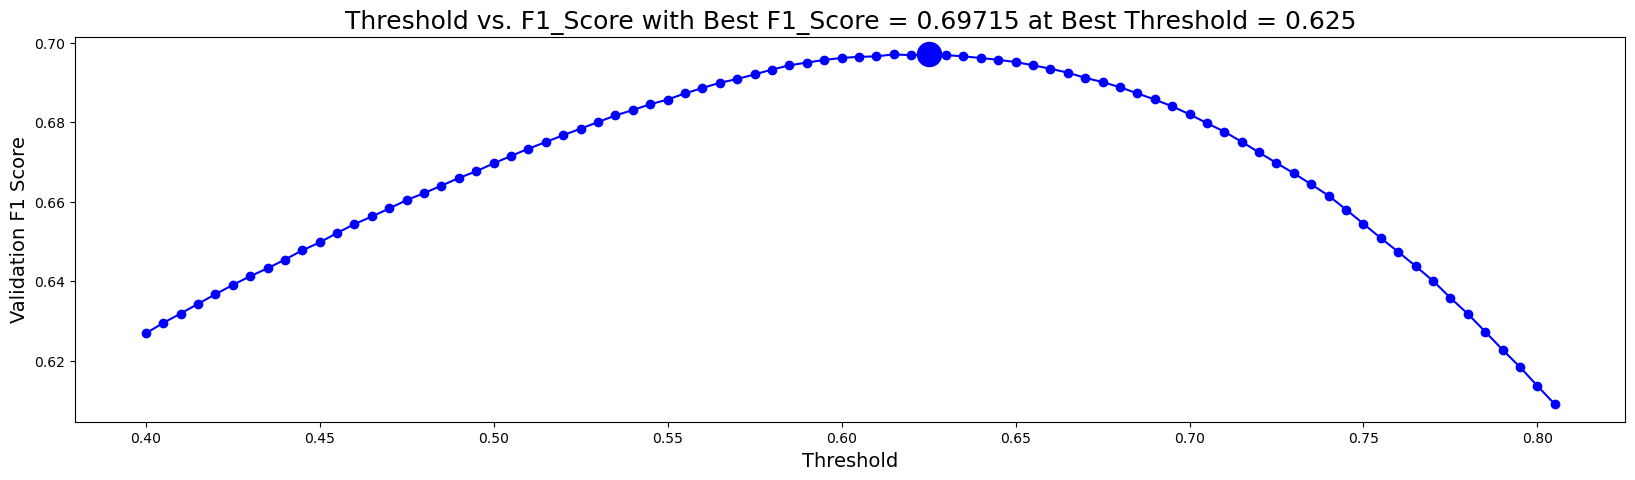

In [ ]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
# plt.savefig('BestThreshold.png')
plt.show()

In [ ]:
try:
    print('When using optimal threshold...')
    for k in range(1, 19):

        # COMPUTE F1 SCORE PER QUESTION
        m = f1_score(true[f'meta_{i}'].values, (oof_xgb[f'meta_{i}'].values>best_threshold_xgb).astype('int'), average='macro')
        print(f'Q{k}: F1 =',m)
        
except:
    print('Something went wrong.....')

When using optimal threshold...
Q1: F1 = 0.4971962372615626
Q2: F1 = 0.4971962372615626
Q3: F1 = 0.4971962372615626
Q4: F1 = 0.4971962372615626
Q5: F1 = 0.4971962372615626
Q6: F1 = 0.4971962372615626
Q7: F1 = 0.4971962372615626
Q8: F1 = 0.4971962372615626
Q9: F1 = 0.4971962372615626
Q10: F1 = 0.4971962372615626
Q11: F1 = 0.4971962372615626
Q12: F1 = 0.4971962372615626
Q13: F1 = 0.4971962372615626
Q14: F1 = 0.4971962372615626
Q15: F1 = 0.4971962372615626
Q16: F1 = 0.4971962372615626
Q17: F1 = 0.4971962372615626
Q18: F1 = 0.4971962372615626


Now we use full data to retrain our models with the best iterations, and save them. 

In [ ]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')
    
    print()

#########################
### question 1 features 695

#########################
### question 2 features 695

#########################
### question 3 features 695

#########################
### question 4 features 1091

#########################
### question 5 features 1091

#########################
### question 6 features 1091

#########################
### question 7 features 1091

#########################
### question 8 features 1091

#########################
### question 9 features 1091

#########################
### question 10 features 1091

#########################
### question 11 features 1091

#########################
### question 12 features 1091

#########################
### question 13 features 1091

#########################
### question 14 features 1283

#########################
### question 15 features 1283

#########################
### question 16 features 1283

#########################
### question 17 features 1283

#########################
### question 18 f

We save features names as dict for each questions

In [ ]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()